In [2]:
import torch
import numpy as np
import pandas as pd
import time
import random
import datetime
import re
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import poisson
%run functions.ipynb
from unidecode import unidecode
plt.rcParams['figure.figsize'] = [13, 7]
pd.set_option("display.precision", 3)


In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
torch.set_printoptions(sci_mode=False)

In [4]:
opp_stats = pd.read_csv('opponent_stats.csv',index_col=0)
schedule = pd.read_csv('schedule.csv',index_col=0)
pdata = pd.read_csv('pdata.csv')
data = pd.read_csv('data_test.csv')
KM_vals = pd.read_csv('KM_vals.csv',index_col=0)

line_list = []

for m in range(3,5):
    for i in range(1, 32):
        file_name = f"Lines/lines{m}_{i}"
        yest_file = f"Lines/lines{m}_{i-1}"
        try:
            # Use globals() to dynamically set the variable name
            globals()[f"lines{m}_{i}"] = pd.read_csv(file_name, index_col=0)
            pp_today = pd.read_csv(file_name, index_col=0)
            pp_yesterday = pd.read_csv(yest_file, index_col=0)
        except FileNotFoundError:
            notfound = file_name
           

In [5]:
data = pd.concat((pdata,data))
data= data.reset_index(drop=True)
data.sample(3)

,Player,G,Date,Series,Tm,H/A,Opp,G#,W/L,GS,...,BLK,TOV,PF,PTS,GmSc,+/-,Pos,KM,Age,PTS_miss
877,Norman Powell,7,2017-05-03,ECS,TOR,0,CLE,2.0,-22,1,...,1,3,4,8,5.4,-24.0,SG,15,NaN,NaN
15039,Mason Plumlee,38,2023-01-02,NaN,CHA,1,LAL,NaN,-6,1,...,2,0,1,18,22.3,1.0,C,15,32-303,98.360
9391,Mikal Bridges,72,2023-03-19,NaN,BKN,1,DEN,NaN,-6,1,...,0,4,2,23,9.8,-16.0,SF,2,26-201,118.018


In [6]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Rest'] = data.groupby('Player')['Date'].diff().dt.days
player_names = data['Player'].unique()


In [7]:
data.loc[data.Player=='Stephen Curry'].sort_values(by='Date')

,Player,G,Date,Series,Tm,H/A,Opp,G#,W/L,GS,...,TOV,PF,PTS,GmSc,+/-,Pos,KM,Age,PTS_miss,Rest
595,Stephen Curry,1,2013-04-20,WC1,GSW,0,DEN,1.0,-2,1,...,5,2,19,11.5,8.0,PG,15,NaN,NaN,NaN
596,Stephen Curry,2,2013-04-23,WC1,GSW,0,DEN,2.0,14,1,...,1,4,30,30.1,15.0,PG,15,NaN,NaN,3.0
597,Stephen Curry,3,2013-04-26,WC1,GSW,1,DEN,3.0,2,1,...,3,4,29,27.2,13.0,PG,15,NaN,NaN,3.0
598,Stephen Curry,4,2013-04-28,WC1,GSW,1,DEN,4.0,14,1,...,2,4,31,30.0,21.0,PG,15,NaN,NaN,2.0
599,Stephen Curry,5,2013-04-30,WC1,GSW,0,DEN,5.0,-7,1,...,2,5,15,8.4,-3.0,PG,15,NaN,NaN,2.0
600,Stephen Curry,6,2013-05-02,WC1,GSW,1,DEN,6.0,4,1,...,7,3,22,15.6,-2.0,PG,15,NaN,NaN,2.0
601,Stephen Curry,7,2013-05-06,WCS,GSW,0,SAS,1.0,-2,1,...,6,3,44,30.4,-2.0,PG,15,NaN,NaN,4.0
602,Stephen Curry,8,2013-05-08,WCS,GSW,0,SAS,2.0,9,1,...,2,2,22,11.8,16.0,PG,15,NaN,NaN,2.0
603,Stephen Curry,9,2013-05-10,WCS,GSW,1,SAS,3.0,-10,1,...,3,3,16,10.1,1.0,PG,15,NaN,NaN,2.0
604,Stephen Curry,10,2013-05-12,WCS,GSW,1,SAS,4.0,10,1,...,2,2,22,16.9,23.0,PG,15,NaN,NaN,2.0


In [8]:
data = data.fillna(5)
data

,Player,G,Date,Series,Tm,H/A,Opp,G#,W/L,GS,...,TOV,PF,PTS,GmSc,+/-,Pos,KM,Age,PTS_miss,Rest
0,Devin Booker,1,2021-05-23,WC1,PHX,1,LAL,1.0,9,1,...,6,4,34,22.1,9.0,SG,15,5,5.000,5.0
1,Devin Booker,2,2021-05-25,WC1,PHX,1,LAL,2.0,-7,1,...,4,3,31,19.1,-16.0,SG,15,5,5.000,2.0
2,Devin Booker,3,2021-05-27,WC1,PHX,0,LAL,3.0,-14,1,...,4,6,19,7.1,-7.0,SG,15,5,5.000,2.0
3,Devin Booker,4,2021-05-30,WC1,PHX,0,LAL,4.0,8,1,...,5,3,17,10.0,12.0,SG,15,5,5.000,3.0
4,Devin Booker,5,2021-06-01,WC1,PHX,1,LAL,5.0,30,1,...,1,3,30,23.5,22.0,SG,15,5,5.000,2.0
5,Devin Booker,6,2021-06-03,WC1,PHX,0,LAL,6.0,13,1,...,3,2,47,39.9,10.0,SG,15,5,5.000,2.0
6,Devin Booker,7,2021-06-07,WCS,PHX,1,DEN,1.0,17,1,...,5,3,21,16.6,12.0,SG,15,5,5.000,4.0
7,Devin Booker,8,2021-06-09,WCS,PHX,1,DEN,2.0,25,1,...,2,1,18,13.6,16.0,SG,15,5,5.000,2.0
8,Devin Booker,9,2021-06-11,WCS,PHX,0,DEN,3.0,14,1,...,4,3,28,17.1,19.0,SG,15,5,5.000,2.0
9,Devin Booker,10,2021-06-13,WCS,PHX,0,DEN,4.0,7,1,...,3,3,34,24.2,10.0,SG,15,5,5.000,2.0


In [9]:
pp_today = pd.read_csv('Lines/pp/pp_2023_10_24.csv',index_col=0)
pp_today = pp_today.loc[~pp_today.player.str.contains('\+')]
pp_today = pp_today.loc[~pp_today.stat.str.contains('Dunks')]

In [10]:
pp_today.stat.unique()

array(['PTS', 'Pass+Rush Yds', 'Rush Yards', 'Pitcher Strikeouts',
       'Pitching Outs', 'Earned Runs Allowed', 'Assists Per Game AVG',
       'Hitter Fantasy Score', 'Double-Doubles', '3PT Made Per Game AVG',
       'Pitches Thrown', 'Pass Yards', 'Technical Fouls',
       'Hits+Runs+RBIS', 'MAPS 1-2 Kills', 'Total Bases',
       'Triple-Doubles', '50+ Point Games', 'Rebounds Per Game AVG',
       'Points Per Game AVG', 'Runs', '30+ Point Games', 'Hits Allowed',
       'Receiving Yards', 'Passes Attempted', 'Shots', 'Shots On Target',
       'Goalie Saves', 'Goals', 'Tackles', 'Clearances', 'Shots Assisted',
       'Shots On Goal', 'AST', 'Fouls', 'Total Games', 'Break Points Won',
       'Aces', 'Points In First 6 Minutes', 'TRB', 'TRB+AST', 'PTS+AST',
       'PTS+TRB', 'PTS+TRB+AST', 'TOV', '3P', 'BLK+STL', 'BLK', 'STL',
       'Time On Ice', 'Hits', 'Faceoffs Won', 'Pass+Rush+Rec TDs',
       'Rush TDs', 'Rec TDs', 'MAP 3 Kills', 'MAP 3 Headshots',
       'MAPS 1-2 Headshots'], d

In [11]:
pp_today.columns

Index(['player', 'team', 'line', 'stat', 'league', 'date', 'time'], dtype='object')

In [31]:
schedule.columns = ['Date','Away','Home']

In [38]:
pp_lines = lines.loc[lines.league==7]
pp_lines = pp_lines.loc[~pp_lines.Stat.str.contains('First')]

In [39]:
lines = pp_lines
p_idx = lines['Player'].unique()
p_idx = np.sort(p_idx)
s_idx = lines['Stat'].unique()
odd = best_odds(lines)
odd['Z'] = (odd['expected']-odd['line'])/odd['line']

In [13]:
pp_today.columns = ['Player', 'Team', 'Line', 'Stat', 'league', 'Date', 'Time']

PTS
line: 3.5
Austin Reaves hits the PTS line 62/66 times or 0.94 %
Austin Reaves hits the PTS line 10/10 times in his last 10


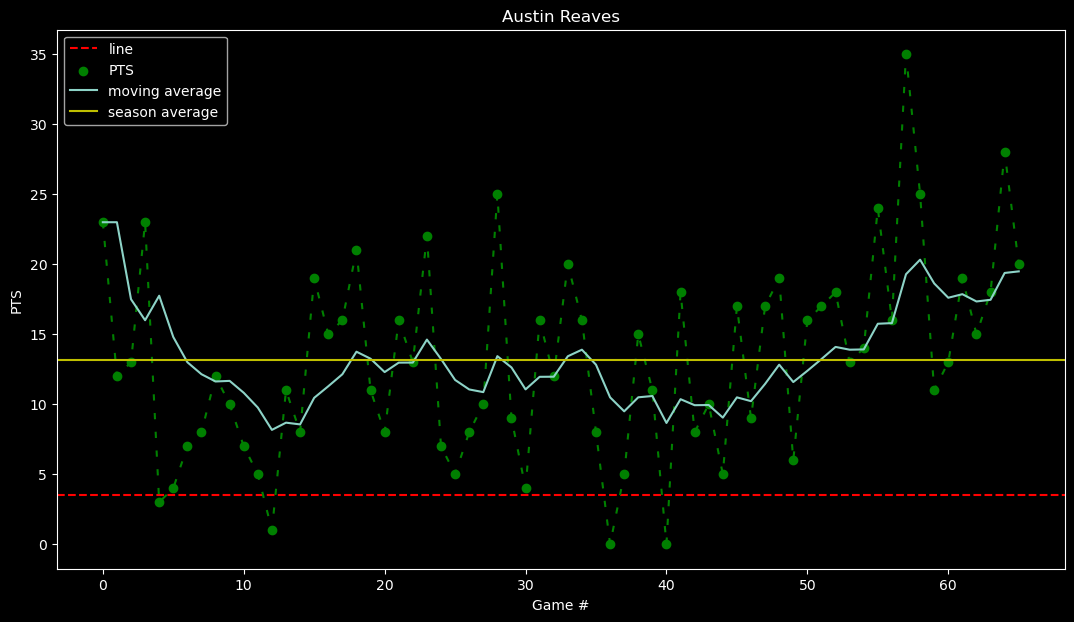

avg: 13.2


In [40]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def graph_stat(player,cat,window,lines):
    print(cat)
    mov = dynamic(player, cat ,window)
    points = np.array(get_stat(player,cat))
    line = get_line(player,cat,lines)
    if line.empty == False:
        line = line.iloc[0,2]
        print('line:',line)
        print_prob(player,line,cat,prnt=True)
        print_prob(player,line,cat,games=10,prnt=True)
            
        plt.axhline(line, color='r', linestyle='--',label='line')
    
    x = range(len(points))
    plt.scatter(x,points, color='g',label=f'{cat}')#games
    plt.plot(x,points, color='g',linestyle=(0, (3, 6)))#game line
    plt.plot(x,mov,label='moving average')#moving average

    plt.axhline(np.mean(points), color='y', linestyle='-',label='season average')
    plt.ylabel(cat)
    plt.xlabel('Game #')
    plt.title(player)
    plt.legend()
    plt.show()
    print('avg:',round(np.mean(points),1))

graph_stat('Austin Reaves','PTS',10,pp_today)

In [41]:
odd = odd[['Player', 'Opp', 'Home', 'Stat','expected','line', 'Last_10', 'Season', 'Prob']]

In [44]:
lines.loc[lines.Player=='Austin Reaves']

,Player,Team,Line,Stat,league,Date,Time
859,Austin Reaves,DEN,1.5,TOV,7,2023-10-24,2023-10-24 10:54:00
860,Austin Reaves,DEN,8.0,TRB+AST,7,2023-10-24,2023-10-24 10:54:00
861,Austin Reaves,DEN,19.5,PTS+AST,7,2023-10-24,2023-10-24 10:54:00
862,Austin Reaves,DEN,18.5,PTS+TRB,7,2023-10-24,2023-10-24 10:54:00
866,Austin Reaves,DEN,4.5,AST,7,2023-10-24,2023-10-24 10:54:00
867,Austin Reaves,DEN,23.0,PTS+TRB+AST,7,2023-10-24,2023-10-24 10:54:00
868,Austin Reaves,DEN,15.5,PTS,7,2023-10-24,2023-10-24 10:54:00
869,Austin Reaves,DEN,1.5,3P,7,2023-10-24,2023-10-24 10:54:00


In [ ]:
from ipywidgets import interact, Dropdown
playerd = Dropdown(options = p_idx)
statd = Dropdown(options = s_idx)

@interact(print(''),player = playerd, stat = statd)
def print_city(player, stat):
    plt.style.use('dark_background')
    statd.options = lines.loc[lines['Player']==player]['Stat'] 
    graph_stat(player,stat,10,lines)
    display(odd.loc[odd['Player']==player].sort_values(by='Prob'))

interactive(children=(Dropdown(description='player', options=('Aaron Gordon', 'Alperen Sengun', 'Andrew Wiggin…

In [43]:
types = Dropdown(options = ['over','under'])
number = Dropdown(options = [10,20])
category = Dropdown(options = np.append('all',s_idx))

@interact(print(' '),types=types, number=number,category=category)
def print_city(types, number,category):
    pd.set_option('display.max_rows', number)
    pd.set_option('display.min_rows', number)
    if category == 'all':
        table = odd.sort_values(by='Prob')
    else:
        table = odd.loc[odd['Stat']==category].sort_values(by='Prob')
    if types == 'over':
        display(table.loc[table['Prob']>0.5].tail(number))
    if types == 'under':
        display(table.loc[table['Prob']<0.5].head(number))

interactive(children=(Dropdown(description='types', options=('over', 'under'), value='over'), Dropdown(descrip…

In [32]:
odd

,Player,Opp,Home,Stat,expected,line,Last_10,Season,Prob
0,Jalen Brunson,CLE,1,AST,6.1,6.0,0.4,0.426,0.410
1,Jalen Brunson,CLE,1,PF,2.2,2.0,0.2,0.382,0.377
2,Jalen Brunson,CLE,1,PTS+TRB+AST,34.5,33.5,0.6,0.500,0.557
3,Jalen Brunson,CLE,1,PTS+TRB,28.4,27.5,0.4,0.456,0.555
4,Jalen Brunson,CLE,1,PTS+AST,31.6,29.5,0.6,0.529,0.636
...,...,...,...,...,...,...,...,...,...
308,Kevin Huerter,GSW,1,FT,0.8,0.5,0.5,0.541,0.551
309,Keegan Murray,GSW,1,FT,0.5,0.5,0.2,0.372,0.393
310,Draymond Green,SAC,1,FT,1.3,0.5,0.6,0.465,0.727
311,Kevon Looney,SAC,1,FT,1.6,0.5,0.8,0.575,0.798


In [33]:
odd.to_csv('ontherun.csv')

In [34]:
def check(lines):
    val = []
    everything = []
    err = 0
    date = lines['Date'][0]
    avail = data.loc[data['Date']< date]
    for i in range(len(lines)):
        if i%10 == 0:
            print(i)
        player = lines['Player'][i]
        date = lines['Date'][i]
        cat = lines['Stat'][i]
        line = lines['Line'][i]
        opp = lines['Team'][i]
        game  = get_game(player,date)
        expect = adjust(player,cat,opp,stats=avail)
        
        if game.empty:
            print('err',player)
            err += 1
        else:
            x = get_stat(player,cat,game)
            pred_diff = expect-line
            diff_real = x-line
            if np.sign(pred_diff) == np.sign(diff_real):
                val=1
            else:
                val=0
            season = float(print_prob(player,line,cat,stats=avail,prnt=False))
            l_10 = float(print_prob(player,line,cat,games=10,stats=avail,prnt=False))
            
            everything.append((player,opp,cat,expect,line,x[0],pred_diff,diff_real[0],val,l_10,season))
            
    x = np.array(everything)
    df = pd.DataFrame(x,columns=['Player','opp','Stat','pred','line','actual','pred_diff','diff_real','Win','l_10','season'])
    numeric = ['pred','line','actual','pred_diff','diff_real','Win','l_10','season']
    df[numeric]=df[numeric].astype(float)
    df['Prob']= 1- poisson.cdf(mu=df['pred'],k=df['line'])
    return df

In [35]:
pp_yesterday = pp_yesterday.replace('Xavier Tillman','Xavier Tillman Sr.')

In [36]:
pd.set_option('display.precision', 2)

df = check(pp_yesterday)
df

0
err LeBron James


KeyError: 'Dunks'

In [ ]:
end= df

In [ ]:
def results(final):
    bets = len(final)
    over_actual = len(final.loc[final['diff_real']>0])
    print(over_actual,bets)
    o_per = over_actual/bets
    under_actual = len(final.loc[final['diff_real']<0])
    u_per = under_actual/bets
    over_pred = len(final.loc[final['pred_diff']>0])
    o_wins = final.loc[final['pred_diff']>0]['Win'].sum()
    
    under_pred = len(final.loc[final['pred_diff']<0])
    u_wins = final.loc[final['pred_diff']<0]['Win'].sum()
    
    print(f'actual over:{over_actual}/{len(final)}, {100*o_per:.0f}%')
    print(f'actual under:{under_actual}/{len(final)}, {100*u_per:.0f}%')
    print('predicted over results',o_wins,over_pred, f'{o_wins/over_pred:.0%}')
    print('predicted under results:',u_wins,under_pred, f'{u_wins/under_pred:.0%}')
    print('overall results:',f'{(o_wins+u_wins)/bets:.0%}')
    return ((o_wins+u_wins)/bets)

In [ ]:
poiss_mid = end.loc[end['Prob']> 0.25]
poiss_low = poiss_mid.loc[poiss_mid['Prob']< 0.75]
results(poiss_mid)

In [ ]:
poiss_low = end.loc[end['Prob']< 0.3]
#poiss_low = poiss_low.loc[poiss_low['season']<0.5]
results(poiss_low)

In [ ]:
poiss_high = end.loc[end['Prob']> 0.7]
#poiss_high = poiss_high.loc[poiss_high['season']>0.5]
results(poiss_high)

In [ ]:
results(pd.concat((poiss_low,poiss_high)))

In [ ]:
parlay = pd.read_csv('parlaylines4_6')
parlay

In [ ]:
new_df = pd.merge(pp_today, dog_today,  how='left', left_on=['Player','Stat','Date'], right_on = ['Player','Stat','Date'],
                 suffixes=['_pp','_dog']) 
new_df

In [ ]:
new_df= new_df.dropna()
line_diff = new_df.loc[new_df['Line_pp'] != new_df['Line_dog']]
line_diff = line_diff.reset_index(drop=True)
line_diff

In [ ]:
new_df

In [ ]:
def best_diff_odds(lines):
    date = lines['Date'].iloc[0]
    home_teams = schedule.loc[schedule['Date']==date]['Home'].values
    player_lines = lines.iloc[:,0]
    avail = data.loc[data['Date']< date]
    player_idx = data['Player'].unique()
    vals = []
    for i in range(len(player_lines)):
        player = lines.iloc[i,0]
        
        if player in player_idx:
            cat = lines.iloc[i,3]
            opp = lines.iloc[i,1]
            if opp in home_teams:
                home = 0
            else:
                home = 1
            mov = dynamic(player, cat ,5,avail)
            series = np.array(get_stat(player,cat))
            line_pp = lines['Line_pp'][i]
            line_dog = lines['Line_dog'][i]
            season = print_prob(player,line_pp,cat,stats=avail,prnt=False)
            l_10 = print_prob(player,line_pp,cat,games=10,stats=avail,prnt=False)
            
            avg = np.mean(series)
            mov_avg = dynamic(player,cat)[-1]
            expected = adjust(player,cat,opp,avail)
            vals.append([player,opp,home,cat,round(avg,1),round(mov_avg,1),round(expected,1),line_pp,line_dog,l_10,season])
          
    odd = pd.DataFrame(vals,columns=['Player','Opp','Home','Stat','Season_avg','mov_avg','expected','line_pp','line_dog','Last_10','Season'])
    odd['blend'] = odd[['Last_10', 'Season']].mean(axis=1) 
    odd['Prob']= 1- poisson.cdf(mu=odd['expected'],k=odd['line_pp'])
            
    return odd

In [ ]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.min_rows', 25)
diff = best_diff_odds(line_diff)

In [ ]:
diff['dog_Prob'] = 1- poisson.cdf(mu=diff['expected'],k=diff['line_dog'])
diff['Prob_diff'] = diff['Prob']-diff['dog_Prob']

In [ ]:
diff.sort_values(by='Prob_diff')

In [ ]:
dog_today.head(2)

In [ ]:
pp_under = diff.loc[(diff['line_pp'] > diff['line_dog']) & (diff['Prob'] < 0.5)]
pp_under.sort_values(by='Prob')

In [ ]:
pp_over = diff.loc[(diff['line_pp'] < diff['line_dog']) & (diff['Prob'] > 0.5)]
pp_over.sort_values(by='Prob')

In [ ]:
dog_under = diff.loc[(diff['line_dog'] > diff['line_pp']) & (diff['Prob'] < 0.5)]
dog_under.sort_values(by='dog_Prob')

In [ ]:
dog_over = diff.loc[(diff['line_dog'] < diff['line_pp']) & (diff['Prob'] > 0.5)]
dog_over.sort_values(by='dog_Prob')

In [ ]:
unabated = pd.read_csv('Lines/unabated', index_col=0)
unabated = unabated.sort_values(by='Prob')
fullpdf = pd.read_csv('Lines/fullpdf', index_col=0)
fullpdf = fullpdf.reset_index(drop=True)

In [ ]:
jak = fullpdf.loc[fullpdf.Player=='Jakob Poeltl']
jak.loc[jak.Stat=='TRB']

In [ ]:
odd.head(2)

In [ ]:
odd['market'] = None

In [ ]:
for i in range(len(odd)):
#    if i % 50 == 0:
#        print(i,'/',len(fullpdf))
    p = odd.Player[i]
    line = odd.line[i]
    stat = odd.Stat[i]
    find = fullpdf.loc[(fullpdf.Player == p)]
    find = find.loc[find.Stat==stat]
    find = find.loc[find.Line==line]
    if len(find) != 0:
        odd.market[i] = find.Prob.mean()

In [ ]:
test = odd.dropna()
test = test.sort_values(by='market')
test

In [ ]:
test.loc[test.Stat=='TRB']

In [ ]:
correlation = pd.read_csv('correlation')
correlation.head(5)

In [ ]:
sorted_odds = odd.sort_values(by='Prob').reset_index(drop=True)
pts = sorted_odds.loc[sorted_odds.Stat=='PTS']
pts

In [ ]:
pts.head(4)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pts = sorted_odds.loc[sorted_odds.Stat=='PTS']
pts = pts.loc[pts.Prob >0.6].reset_index(drop=True)
players = pts.Player.unique()
for i in range(len(pts)): 
    p = pts.Player[i]
    guycorr = correlation.loc[correlation.P1 == p]
    guycorr = guycorr.loc[guycorr['P2'].isin(players)]
    guycorr = guycorr.loc[abs(guycorr.Corr) > 0.15]
    if guycorr.empty == False:
        print(p)
        display(guycorr)
        mainline = pts.iloc[i]
        for j in guycorr.P2:
            corrguy = pts.loc[pts.Player==j]
            mainline = pd.concat((corrguy.T,mainline.T),axis=1).T
        display(mainline)

In [ ]:
pts

In [ ]:
odd.to_csv('ontherun.csv')